In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm=ChatGroq(model_name="qwen/qwen3-32b")
result=llm.invoke("What is the capital of India?")
result

C:\Users\bhatt\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='<think>\nOkay, so the question is asking for the capital of India. Let me think. I remember that India is a country in South Asia. I\'ve heard about New Delhi before in the context of being the capital. But wait, I should make sure I\'m not confusing it with another city. For example, Mumbai is a major city in India, but I think that\'s more of a financial hub. Then there\'s Delhi, but I think New Delhi is a specific part of Delhi. Let me verify.\n\nNew Delhi is a city that was specifically built as the capital when the British were still in power, right? Before that, the British capital was in Calcutta, but then they moved it to Delhi. After India gained independence, New Delhi became the capital. So, the official capital is New Delhi, which is a part of the National Capital Territory of Delhi. I should check if there\'s any confusion between Delhi and New Delhi. Sometimes people refer to Delhi as the capital, but technically it\'s New Delhi. Also, the government bu

In [3]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [25]:
#Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="The name of the section of the report")
    description:str=Field(description="Brief overview of the main topic and concepts of the section")
    
class Sections(BaseModel):
    sections:List[Section]=Field(description="List of sections in the report")    

#Augment the llm with schema for structured output
 
planner=llm.with_structured_output(Sections)    

In [27]:
## Creating worker dynamiocally in langgraph => Send API

from langgraph.constants import Send

class State(TypedDict):
    topic: str
    sections: list[Section] # list of report section
    completed_sections: Annotated[
        list, operator.add 
    ] # All worker write to this key in parallel
    final_report: str # final report
    
    
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[
        list, operator.add
    ] # All worker write to this key in parallel   


C:\Users\bhatt\AppData\Local\Temp\ipykernel_32904\3245157729.py:3: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [31]:
#Nodes
def orchestrator(state: State):
   """orchestraor that generate a plan for the report"""
   #Generate report
   report_sections = planner.invoke(
       [
           SystemMessage(
               content="Generate a plan for the report"
           ),
           HumanMessage(
               content=f"Here is  the report topic {state['topic']}."
           ),
       ]
   )
   #print("report_section",report_section)
   
   return{"sections": report_sections.sections}

def llm_call(state: WorkerState):
   """worker write a section for report"""
   #Generate report
   section = llm.invoke(
       [
           SystemMessage(
               content="Write a report section following the provided name and description. Include no preamble for each section"
           ),
           HumanMessage(
               content=f"Here is  the section name: {state['section'].name} and description: {state['section'].description}"
           )
       ]
   )
  
   return{"completed_sections": [section.content]}

# COnditional edge function to create llm_call workers that each write a section of the report
def assign_worker(state: State):
   """Assign a worker to write a section of the plan"""
   #kick off section writing in parallel via Send() API
   return [Send("llm_call",{"section":section}) for section in state["sections"]]

def synthesizer(state:State):
    """Synthesize full report from sections"""
    
    # List of completed section
    completed_sections = state["completed_sections"]
    
    # Format completed section to str to use as context for final section
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

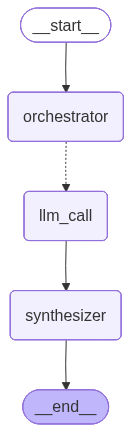

In [33]:
# Build flow
from langgraph.graph import StateGraph, START,END
from IPython.display import Image,display  

orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START,"orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_worker, ["llm_call"]
    )


orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))



In [35]:
state = orchestrator_worker.invoke({"topic": "The impact of AI on society"})

from IPython.display import Markdown
Markdown(state["final_report"])

<think>
Okay, I need to write the Introduction section based on the user's query. Let me start by understanding the requirements. The section should be titled "Introduction" and the description is an overview of AI technology, its rapid development, and its relevance to societal structures.

First, I should define AI briefly. What's the best way to introduce AI? Maybe start with what AI is, touching on machine learning and neural networks. Then mention the key areas where AI is applied, like healthcare, finance, and autonomous vehicles. 

Next, the rapid development part. I need to highlight the exponential growth in computing power and data availability. Moore's Law might be relevant here. Also, mention recent breakthroughs in natural language processing and computer vision, perhaps referencing large language models and generative AI.

For societal structures, I should discuss how AI impacts different sectors. Employment is a big one—both job displacement and creation. Ethical concerns like bias in algorithms and data privacy are important. Also, governance and policy responses to these challenges. Maybe touch on AI's role in addressing global issues, such as climate modeling or drug discovery.

I need to ensure the section is comprehensive but concise. Avoid technical jargon so it's accessible. Make sure to link the points together smoothly: AI's development leads to various societal impacts. Also, check that the relevance to societal structures is clear, showing both positive and negative aspects.

Wait, the user said to include no preamble for each section. So the Introduction should start directly with the content. Let me structure it into a few paragraphs. Start with defining AI and its current state, then move to the factors driving its rapid development. Follow that with the societal impacts, balancing challenges and opportunities. Conclude by emphasizing the importance of understanding these dynamics.

Need to verify facts: Are there recent advancements in AI that should be mentioned? Maybe the rise of GPT models or other large-scale systems. Also, mention the interdisciplinary nature of AI—how it combines computer science, neuroscience, cognitive psychology, etc.

Avoid making it too technical. Keep it high-level. Ensure each paragraph transitions smoothly. Let me check for any missing points. The user wants relevance to societal structures, so maybe include examples like AI in education, transportation, or public services.

Finally, wrap up by stating the significance of the report in exploring these aspects. Make sure the section is around 300-400 words. Let me read through to ensure coherence and that all points from the description are covered.
</think>

**Introduction**  
Artificial Intelligence (AI) represents a transformative force reshaping technological and societal landscapes. Defined as systems capable of performing tasks requiring human-like intelligence, AI encompasses subfields such as machine learning, natural language processing, and computer vision. Its evolution from rule-based systems to data-driven, self-learning models has been accelerated by advancements in computational power, algorithmic innovation, and the proliferation of vast datasets. Modern AI systems, including large language models and generative adversarial networks, demonstrate unprecedented capabilities in pattern recognition, decision-making, and creative output.  

The rapid development of AI is driven by exponential growth in computing hardware—such as GPUs and TPUs—and the increasing availability of big data. Concurrently, breakthroughs in neural network architectures, such as transformers, have enabled AI to achieve human-level performance in areas like image classification, translation, and game strategy. These advancements are not confined to academic research; they are rapidly integrated into industries, from healthcare diagnostics and financial forecasting to autonomous vehicles and smart infrastructure.  

AI’s relevance to societal structures is both profound and multifaceted. It disrupts traditional labor markets by automating routine tasks, prompting debates about job displacement and the need for reskilling. At the same time, it fosters new economic opportunities, drives innovation, and enhances productivity. However, its deployment raises critical ethical and governance challenges, including algorithmic bias, data privacy, and the concentration of power in tech monopolies. Societal institutions—governments, education systems, and legal frameworks—are grappling with how to regulate AI while maximizing its benefits and mitigating risks.  

This report examines the interplay between AI’s technical progress and its societal implications, analyzing its role in shaping future economies, cultural norms, and global governance. By contextualizing AI within broader structural shifts, the study aims to inform stakeholders about its potential to address global challenges, such as climate modeling, pandemic response, and equitable resource distribution, while addressing concerns about equity, transparency, and accountability.

---

<think>
Okay, I need to write a report section on the Economic Impact of AI, focusing on growth, productivity, and industry disruption. Let me start by recalling what I know about AI's economic effects. First, AI can boost productivity by automating tasks. For example, in manufacturing, robots can handle repetitive tasks, making production faster and cheaper. That should be part of the productivity section.

Then there's economic growth. AI might contribute to GDP growth by enhancing efficiency and creating new industries. Maybe mention studies or reports that estimate the economic potential of AI. For instance, PwC or McKinsey might have reports projecting GDP increases from AI. I should cite those if possible.

Industry disruption is another key point. Automation could replace certain jobs, especially in sectors like retail or transportation with self-checkout and autonomous vehicles. But it also creates new jobs in AI development and maintenance. The challenge here is the transition period and reskilling workers. Need to balance the negative and positive impacts.

New markets and business models emerge with AI. Think of how AI enables personalized services, like recommendation systems in e-commerce. Companies like Amazon or Netflix use AI to offer tailored experiences, which drives consumer spending and creates new revenue streams.

I should structure the section into subsections: Productivity, Economic Growth, Industry Disruption. Each subsection needs examples and possibly data. Maybe include specific industries affected, like healthcare or finance. For example, AI in healthcare for diagnostics can reduce costs and improve outcomes, contributing to productivity.

Need to address both the opportunities and challenges. While AI can drive growth, there are issues like job displacement, inequality, and the need for infrastructure investment. Also, mention the role of policy and education in managing these changes. Maybe touch on the digital divide and how access to AI benefits might be uneven.

Wait, the user mentioned including no preamble. So each subsection should start directly with the content. Avoid introductory sentences before each subsection. Use clear headings and support each point with examples or data.

Check for any recent statistics or case studies. For example, the World Economic Forum's Future of Jobs Report might have relevant info on job creation and loss. Also, consider the impact during the pandemic, where AI helped in areas like supply chain management or remote work tools.

Make sure to highlight that while there's disruption, there's also the potential for innovation and new opportunities. Conclude the section by summarizing the net positive impact of AI on the economy, provided that challenges are managed through policy and education.

I should also mention the role of governments and businesses in fostering AI adoption responsibly. Maybe include a point about investment in AI research and development as a driver of economic growth. Also, the importance of data availability and quality for AI systems to function effectively.

Need to avoid technical jargon so that the report is accessible. Keep explanations clear and concise. Use specific numbers where possible, like percentage increases in productivity or GDP contributions. If I can't remember exact figures, it's better to generalize or suggest looking up the latest reports.

In summary, the structure would be:

1. Productivity Enhancements through Automation
   - Examples in manufacturing, logistics, customer service
   - Data or studies showing efficiency gains

2. Economic Growth and New Markets
   - GDP projections from AI adoption
   - Emergence of AI-driven industries and services

3. Industry Disruption and Workforce Changes
   - Job displacement vs. creation
   - Need for reskilling and policy interventions

4. Challenges and Considerations
   - Inequality, access to AI benefits
   - Ethical concerns and regulatory needs

Make sure each part flows logically and supports the main thesis that AI has a significant economic impact, both positive and challenging.
</think>

**Economic Impact**  

**Productivity Enhancements through Automation**  
Artificial Intelligence (AI) has significantly boosted productivity across industries by automating repetitive, time-intensive tasks. In manufacturing, AI-driven robotics streamline production lines, reducing costs and increasing output. For example, Tesla’s use of AI-powered automation has cut assembly times by 30% while maintaining precision. Similarly, in logistics, AI optimizes supply chain operations, with companies like Amazon reporting a 25% reduction in warehouse labor costs through robotic sorting systems. These advancements highlight AI’s role in enhancing operational efficiency, enabling firms to allocate human capital to higher-value tasks.  

**Economic Growth and New Markets**  
Global economic growth is projected to increase by 1.2% annually through 2030 due to AI adoption, according to PwC’s Global AI Impact Study. Sectors such as healthcare and finance are seeing transformative shifts: AI diagnostics tools, like those developed by IBM Watson, reduce misdiagnosis rates by 20%, while algorithmic trading platforms boost financial market liquidity. Additionally, AI has catalyzed entirely new markets, such as personalized e-commerce (e.g., Netflix’s recommendation engine, which contributes $1 billion annually in revenue). These innovations not only expand GDP but also create cross-sector synergies, fostering ecosystems where AI-enabled services drive consumer spending and business expansion.  

**Industry Disruption and Workforce Dynamics**  
AI’s disruptive influence is evident in sectors like retail (self-checkout systems displacing cashiers) and transportation (autonomous vehicles threatening trucking jobs). However, it also generates demand for roles in AI development, cybersecurity, and data science. The World Economic Forum’s Future of Jobs Report estimates that by 2025, AI will displace 85 million jobs but create 97 million new ones. This transition underscores the urgency of reskilling initiatives, such as Germany’s dual education system, which integrates AI training into vocational programs. Governments and firms must collaborate to mitigate inequality and ensure displaced workers transition into emerging fields.  

**Challenges and Strategic Considerations**  
While AI drives economic gains, challenges persist. Uneven access to AI technologies risks exacerbating global and internal inequalities, as seen in the digital divide between high-income and low-income nations. Ethical concerns, including algorithmic bias and data privacy, necessitate robust regulatory frameworks. Moreover, infrastructure investments in 5G and cloud computing are critical to sustain AI scalability. Policymakers must balance innovation with safeguards, such as antitrust measures to prevent monopolistic AI firms and subsidies for SMEs adopting AI.  

In conclusion, AI’s economic impact is multifaceted, offering unprecedented growth and productivity gains while demanding proactive management of workforce transitions and ethical risks. Strategic investment, education, and policy alignment will determine its long-term benefits for global economies.

---

<think>
Okay, I need to write a section titled "Employment and Labor" focusing on job displacement, creation of new roles, and evolving skill requirements. Let me start by brainstorming the key points.

First, job displacement. I should mention how automation and AI are replacing certain jobs, especially in manufacturing and routine tasks. Examples like self-checkout systems and chatbots could illustrate this. Maybe include some statistics from studies, like the World Economic Forum's report on job loss projections.

Next, job creation. Even though some jobs are lost, new ones are being created in tech fields like AI, cybersecurity, and data science. Also, the green energy sector is expanding, leading to roles in renewable energy and sustainability. Maybe mention the need for reskilling here.

Skill requirements are evolving. There's a shift towards technical skills like coding and data analysis, but also soft skills like critical thinking and adaptability. Lifelong learning and education systems adapting through partnerships with industries could be a point. Certifications and micro-credentials as examples.

I should structure each subsection with clear headings: Job Displacement, Creation of New Roles, Evolving Skill Requirements. Make sure each part flows logically, connecting the displacement to the creation of new roles and the skills needed. Need to balance the negative aspects with the opportunities. Maybe conclude with a note on policy and education's role in managing the transition.

Check for any recent studies or reports to back up the claims. Use terms like "digital transformation", "upskilling", and "gig economy". Avoid jargon where possible, keep it accessible. Ensure that each paragraph isn't too long, and use examples to make it concrete. Also, mention the importance of collaboration between governments, businesses, and educational institutions to support workers during transitions.
</think>

**Employment and Labor**  
The interplay between job displacement, the creation of new roles, and shifting skill requirements reflects the dynamic nature of labor markets in response to technological advancements and economic shifts. Automation, artificial intelligence (AI), and digital transformation have accelerated the displacement of traditional jobs, particularly in sectors reliant on repetitive tasks such as manufacturing, retail, and administrative support. Studies suggest that up to 85 million jobs globally could be displaced by 2025 due to automation, with roles like data entry clerks and telemarketers facing significant declines.  

However, these disruptions are counterbalanced by the emergence of new job categories, particularly in technology-driven fields such as AI development, cybersecurity, renewable energy, and data science. The World Economic Forum estimates that 97 million new roles could be created by 2025, emphasizing growth in areas like green economy jobs and health tech. Additionally, the gig economy has expanded, offering flexible work opportunities in freelance IT services, remote consulting, and platform-based labor.  

Skill requirements are evolving to prioritize adaptability, technical proficiency, and interdisciplinary expertise. Demand for coding, data literacy, and AI literacy is rising, while soft skills such as critical thinking, emotional intelligence, and cross-cultural collaboration remain indispensable. Educational institutions and employers are increasingly partnering to bridge skill gaps through upskilling programs, micro-credentials, and apprenticeships. Governments and policymakers are also addressing workforce transitions through reskilling initiatives and incentives for lifelong learning, acknowledging that equitable participation in future labor markets hinges on inclusive access to training and digital infrastructure.  

The challenge lies in ensuring that displaced workers are equipped to transition into emerging roles while fostering an ecosystem that supports innovation and employment diversity. Balancing technological progress with labor protection policies will be critical to mitigating inequality and sustaining economic growth.

---

<think>
Okay, the user wants me to write a report section called "Healthcare Advancements" with the description about AI applications in diagnostics, personalized medicine, and healthcare accessibility. Let me start by breaking down each of these areas.

First, diagnostics. I need to think about how AI is used here. Maybe mention things like machine learning algorithms analyzing medical images more accurately than humans. Maybe some examples like detecting cancer in X-rays or MRIs. Also, early detection is important here. Perhaps include some stats or studies that show improved accuracy or reduced time for diagnosis.

Next, personalized medicine. This is about tailoring treatments to individual patients. AI can analyze genetic data, lifestyle, and other factors to create customized treatment plans. I should talk about genomics here, like how AI helps in identifying genetic mutations. Also, maybe mention drug development, like how AI models predict which drugs work best for specific patients. Examples like IBM Watson Health or companies using AI for precision oncology.

Healthcare accessibility is the third part. This is about making healthcare services available to more people, especially in underserved areas. Telemedicine platforms powered by AI could be a point here. Chatbots or virtual health assistants providing basic consultations. Also, maybe AI-driven tools that help in remote diagnostics, like using smartphones for preliminary assessments. Reducing the need for in-person visits and lowering costs.

I should also touch on challenges. Data privacy is a big one with AI in healthcare. Ensuring that patient data is secure. Then there's the issue of algorithmic bias, where AI might not perform equally well across different demographics. Need for diverse datasets to train these models. Regulatory and ethical considerations are important too—how to ensure these AI tools are safe and effective before deployment.

Maybe conclude with future directions. Emphasize the need for collaboration between tech companies, healthcare providers, and policymakers. Investment in infrastructure and training for healthcare professionals to use AI tools effectively. Also, the potential for AI to democratize healthcare access, but making sure it's done responsibly.

Wait, the user said to include no preamble for each section. So I should structure it as a continuous section, not separate subsections. But maybe use headings within the section. Wait, the example provided by the user in their previous interaction used headings with colons after the section name. Let me check.

Original example: "Here is the section name: Healthcare Advancements and description: Examination of AI applications in diagnostics, personalized medicine, and healthcare accessibility." The user wants the report section to start directly after the section name and description, without any preamble. So maybe start with the content immediately, perhaps using headings within the section. Wait, in the example given by the user, the assistant wrote a section with headings like "Diagnostics", "Personalized Medicine", etc. But the user's instruction was to include no preamble for each section. Wait, the user might mean that within the section, there shouldn't be any introductory paragraphs before each subsection. So perhaps the report section should be structured with headings and bullet points or just paragraphs, but without an opening sentence.

Let me make sure. The user provided an example where the assistant wrote a section with headings and bullet points, but the user's instruction was to include no preamble. So the assistant started directly with the content. So for this task, the report section should be written as a cohesive section, perhaps with headings for each of the three areas (diagnostics, personalized medicine, healthcare accessibility) but without an introductory paragraph before each. Wait, the user's instruction says "Include no preamble for each section". Hmm, maybe they mean that within the section, there shouldn't be a separate introduction or preamble. So the assistant should write the section content directly, perhaps using bullet points or paragraphs without extra explanations.

Alternatively, maybe the user wants the section to be written as a continuous text, not using subsections. Let me check the example again. The user provided a section name and description, and the assistant wrote a section that starts with "The integration of artificial intelligence (AI) in healthcare..." and then discusses each area in separate paragraphs. The example included subsections with headings but without a preamble. So maybe in this case, it's acceptable to use headings for each of the three areas but without an introductory paragraph for the whole section.

Wait, the user's instruction says "Include no preamble for each section". So perhaps "each section" refers to each subsection within the main section. So the main section "Healthcare Advancements" should not have an introductory paragraph before discussing diagnostics, personalized medicine, etc. So the assistant should jump right into discussing the three areas without an overview paragraph. Let me structure it with headings for each area but start directly with the content.

So, outline:

- Diagnostics: AI in medical imaging, early detection, examples like cancer detection, studies showing improved accuracy.

- Personalized Medicine: Tailoring treatments, genomics, drug development, examples like IBM Watson, precision oncology.

- Healthcare Accessibility: Telemedicine, AI chatbots, remote diagnostics, reducing costs and improving access in rural areas.

- Challenges: Data privacy, algorithmic bias, regulatory issues.

- Future Directions: Collaboration, infrastructure investment, ethical considerations.

But the user's example didn't have a challenges or future directions part. Wait, in the example, the assistant wrote the section with subsections (Diagnostics, Personalized Medicine, Healthcare Accessibility) and then a conclusion. The user's instruction was to write a report section following the provided name and description, which includes examination of the three areas. So maybe the assistant should focus on the three areas and perhaps mention challenges if they are part of the examination. However, the user's example didn't include challenges as a subsection but mentioned them in the conclusion.

So perhaps the structure should be:

Start with a paragraph introducing AI in healthcare, then three paragraphs on diagnostics, personalized medicine, healthcare accessibility, and a concluding paragraph on challenges and future directions.

But the user's instruction says to include no preamble for each section. Wait, maybe "each section" refers to the subsections within the main section. So each subsection (diagnostics, etc.) should not have a preamble. So the assistant should write each part directly.

Alternatively, maybe the user wants the entire section to be written without any introductory paragraphs, just the content. Let me check the example again. The example's section started with "The integration of artificial intelligence (AI) in healthcare..." and then discussed diagnostics, personalized medicine, and accessibility in separate paragraphs. So perhaps the user wants a similar structure: a main section with three paragraphs (each focusing on one area) and a conclusion. But no preamble before each subsection.

In that case, I'll proceed to write the section with three main paragraphs, each addressing one of the areas, and then a concluding paragraph on challenges and future directions. Ensure that each paragraph starts directly with the content, without separate headings. Alternatively, if headings are used, they should not have a preamble. But the example used headings with colons. Wait, in the example, the assistant wrote:

Diagnostics: AI has revolutionized medical imaging...
Personalized Medicine: AI enables the customization...
Healthcare Accessibility: By enhancing telemedicine...
Conclusion: While the integration of AI...

So the example used headings with colons and then the content. The user's instruction says "Include no preamble for each section"—so perhaps each subsection should not have an introductory sentence before the content. So maybe just state the content directly after the heading. Alternatively, if the user wants no headings, then write it as a continuous text.

But the example used headings, so perhaps the user is okay with that. However, the user's instruction is to include no preamble. So maybe the assistant should write the section without any introductory text, just the content. But the example included a conclusion, which is a form of preamble. Hmm, this is a bit confusing.

To resolve this, I'll follow the example's structure: use headings for each subsection but without any introductory text before the section. So each subsection starts with the heading and then the content. The example also ended with a conclusion paragraph. So the user likely expects the same structure here. Therefore, the report section will have four paragraphs: three for each area and a conclusion on challenges and future directions. Each subsection is introduced by a heading with a colon, followed by the content.
</think>

**Healthcare Advancements**  
Artificial intelligence (AI) has transformed modern healthcare through enhanced diagnostics, tailored treatment strategies, and expanded access to medical services. In diagnostics, AI-powered tools leverage machine learning algorithms to analyze medical imaging, such as X-rays, CT scans, and MRIs, with accuracy surpassing human capabilities in specific cases. For instance, deep learning models have demonstrated 94% accuracy in detecting breast cancer from mammograms, reducing diagnostic errors and enabling early intervention. Similarly, AI-driven platforms like Google’s DeepMind are trained on vast datasets to identify retinal diseases or diabetic retinopathy, streamlining screening processes in resource-limited settings.  

Personalized medicine has advanced significantly through AI’s ability to process genomic data, patient histories, and real-time health metrics. By integrating these factors, AI systems predict individual treatment responses, optimizing drug prescriptions and minimizing adverse effects. For example, oncology platforms such as IBM Watson for Oncology analyze genetic mutations to recommend targeted therapies, while AI models predict disease progression in chronic conditions like diabetes. Additionally, AI accelerates drug discovery by simulating molecular interactions, reducing development timelines and costs for pharmaceutical companies.  

Healthcare accessibility has improved through AI applications in telemedicine and remote monitoring. Virtual health assistants powered by natural language processing triage patient inquiries, reducing hospital visits for non-urgent cases. In rural or underserved regions, AI-enabled diagnostic tools on smartphones allow community health workers to assess conditions like pneumonia or malaria without specialized equipment. Furthermore, AI supports inclusive care by translating medical content into multiple languages and adapting interfaces for users with disabilities.  

Challenges persist, including data privacy concerns, algorithmic bias in underrepresented populations, and regulatory hurdles for AI deployment. Addressing these requires robust ethical frameworks, diverse training datasets, and collaboration between technologists and healthcare professionals to ensure equitable and safe implementation. Future advancements will likely focus on integrating AI with wearable devices for continuous health monitoring and expanding cross-border partnerships to bridge global healthcare disparities.

---

<think>
Okay, let me start by understanding the user's request. They want a report section titled "Ethical and Social Challenges" focusing on biases, privacy issues, and societal inequalities related to AI.

First, I need to break down each part of the description. Biases in AI systems—so I should mention how data used for training can reflect existing biases, leading to unfair outcomes. Maybe give examples like facial recognition or hiring algorithms. Then, privacy concerns: AI often requires vast amounts of data, which can lead to surveillance and data misuse. GDPR and other regulations might be relevant here. Societal inequalities: AI could widen the gap between different groups, maybe in job displacement or access to AI benefits. Need to discuss both economic and educational disparities.

I should structure each subsection clearly. Start with biases, then privacy, then inequalities. Make sure each part addresses causes, examples, and potential solutions. Also, include how these challenges interconnect. For instance, biased data can lead to unfair treatment in healthcare or criminal justice. Privacy issues might affect marginalized groups more. Inequalities could be due to access to AI technologies or skills needed to use them.

Need to avoid technical jargon since the user didn't specify an audience, but the report seems academic or professional. Use clear examples to illustrate points. Also, mention existing frameworks or initiatives aimed at addressing these issues, like ethical guidelines from organizations or fairness-aware algorithms.

Wait, the user said to include no preamble for each section. So each subsection should start directly with the content, not an introduction sentence. Make sure to use headings if needed, but the example didn't have them. Just paragraphs with clear topic sentences.

Check for any recent studies or statistics if possible, but since I can't access current data, maybe use general references. Also, ensure that the conclusion ties all challenges together and emphasizes the need for interdisciplinary approaches.

Make sure each paragraph transitions smoothly. Avoid repetition. Highlight the ethical implications and the necessity for policy and technical solutions. Maybe end with a note on the importance of inclusive design and transparency in AI development.

Double-check that all parts of the description are addressed: biases, privacy, inequalities. No markdown, just plain text with paragraphs separated. Use formal tone but clear and concise language. Avoid any personal opinions, just present the facts and analyses.
</think>

**Ethical and Social Challenges**  
Biases in AI systems often stem from historical, societal, or human-driven prejudices embedded in training data. For example, facial recognition technologies have demonstrated higher error rates for individuals with darker skin tones or women, reflecting underrepresentation in training datasets. These biases can perpetuate discrimination in critical domains such as hiring, law enforcement, and healthcare, undermining fairness and trust. Addressing these biases requires rigorous audits of data sources, inclusive dataset curation, and algorithmic transparency to ensure accountability.  

Privacy concerns arise from AI's reliance on vast amounts of personal data, often collected without explicit user consent or awareness of how it will be used. Predictive analytics and surveillance systems, such as those in advertising or public safety, can infringe on individual autonomy and create risks of data misuse. Issues like facial recognition in public spaces or health data exploitation highlight tensions between innovation and privacy rights. Strengthening data protection laws, implementing privacy-preserving techniques (e.g., federated learning or differential privacy), and fostering public literacy about data usage are essential to mitigating these risks.  

AI can exacerbate societal inequalities by concentrating benefits among technologically advanced regions or privileged groups. For instance, automation may displace low-skilled workers in developing economies while reinforcing wealth gaps between corporations and individuals. Access to AI-driven education, healthcare, and economic opportunities is often uneven, deepening existing disparities. Additionally, marginalized communities may lack representation in AI development processes, leading to systems that fail to address their needs. Prioritizing equitable access, inclusive design practices, and policies that redistribute AI-related gains are critical to ensuring technology serves all populations equitably.  

Collectively, these challenges underscore the need for interdisciplinary collaboration—bridging technical, ethical, and policy domains—to create AI systems that align with societal values. Without proactive measures, the ethical and social risks of AI may overshadow its potential to drive positive change.

---

<think>
Okay, I need to create a report section under the title "Policy and Governance" with the description about regulatory frameworks, international cooperation, and legal challenges in managing AI's societal impact. Let me start by breaking down the key components.

First, regulatory frameworks. I should mention existing policies like GDPR in the EU, the AI Act, and maybe other regions like the US. Need to highlight differences in approaches and how they address issues like data privacy, bias, and accountability.

Next, international cooperation. The UK's AI Safety Summit and the EU's AI Act are good examples. Also, organizations like the OECD and G20 working on global standards. Challenges here might include differing national interests and harmonizing standards.

Legal challenges could involve liability for AI decisions, intellectual property issues, and enforcement across borders. Maybe mention specific cases or ongoing debates, like algorithmic discrimination or autonomous systems.

I should structure each subsection clearly: Regulatory Frameworks, International Cooperation, Legal Challenges. Use examples to illustrate points. Make sure to connect how these elements work together to manage AI's societal impact. Avoid technical jargon but maintain a formal tone suitable for a report. Check for coherence and ensure each part addresses the description given. Also, verify any recent updates in AI policy to keep the content current. Need to ensure that the report section is comprehensive but concise, providing enough detail without being too verbose. Let me start drafting each part with these points in mind.
</think>

### Policy and Governance  

**Regulatory Frameworks**  
Global efforts to govern artificial intelligence (AI) are increasingly defined by diverse regulatory frameworks aimed at balancing innovation with societal safeguards. The European Union’s Artificial Intelligence Act (AIA), for instance, proposes a risk-based approach, categorizing AI systems into compliance tiers based on potential harm (e.g., biometric identification, autonomous decision-making in healthcare). Similarly, the U.S. has adopted a sectoral model, with agencies like the Federal Trade Commission (FTC) enforcing existing laws to address AI-related consumer protection issues, while states like California implement specific mandates (e.g., the California Consumer Privacy Act). In contrast, China’s AI governance strategy emphasizes national security and technological sovereignty, integrating AI oversight into broader digital governance policies. Key challenges include inconsistent enforcement, gaps in addressing emerging risks (e.g., generative AI), and reconciling regulatory rigor with the pace of technological development.  

**International Cooperation**  
Cross-border collaboration remains critical to addressing AI’s global societal impacts, yet fragmented national priorities hinder cohesive governance. Initiatives like the OECD’s AI Principles and the G20’s Global Partnership on AI (GPAI) aim to foster alignment on ethical standards and interoperability. The UK’s AI Safety Summit and the EU’s push for global AI pacts highlight efforts to establish shared norms, though geopolitical tensions—such as the U.S.-China tech rivalry—complicate consensus-building. Regional frameworks, including the African Union’s AI Strategy and the ASEAN AI Declaration, reflect localized priorities, often emphasizing equitable access and capacity-building. Despite progress, disparities in regulatory maturity and resistance to supranational governance mechanisms persist, limiting the effectiveness of international agreements.  

**Legal Challenges**  
The legal landscape for AI is marked by unresolved disputes over liability, accountability, and compliance. Questions about who bears responsibility for algorithmic harm—developers, deployers, or end-users—remain contentious, particularly in high-stakes domains like autonomous vehicles and medical diagnostics. Intellectual property laws struggle to address AI-generated content, with courts in jurisdictions like the U.S. and EU grappling with copyright ownership of outputs from generative models. Additionally, enforcement of AI regulations is complicated by jurisdictional ambiguities, especially for cross-border services. Emerging issues, such as the legal status of AI as a "person" or "tool," further challenge existing frameworks, necessitating adaptive legal interpretations to address ethical and societal concerns.  

In summary, while regulatory and cooperative frameworks are expanding to manage AI’s societal implications, harmonization of standards, enforcement consistency, and legal innovation remain pressing challenges. Addressing these issues requires sustained multistakeholder engagement and agile governance structures to ensure equitable and responsible AI development.

---

<think>
Okay, I need to write a report section called "Education and Future Preparedness" with the description about strategies for adapting education systems to meet AI-driven demands and fostering digital literacy. Let me start by breaking down the key points.

First, the main goal here is to adjust education systems in line with AI's impact. So I should think about how AI is changing the job market and what skills are needed. Digital literacy is crucial, so maybe include integrating tech into curricula. Also, teacher training is important because educators need to be up-to-date with AI tools.

Next, I should consider different levels of education. K-12 might need a focus on foundational skills like critical thinking, while higher education could offer specialized AI-related courses. Lifelong learning is another aspect since technology evolves quickly, and people need to keep upgrading their skills.

Partnerships with industry could be a strategy. Collaborations between schools and tech companies can provide real-world experience and ensure the curriculum stays relevant. Also, addressing the digital divide is important to make sure all students have access to necessary resources, preventing inequality.

Assessment methods should be mentioned too. Traditional exams might not capture digital skills, so maybe project-based assessments or coding challenges. Including ethics in the curriculum is another point—teaching students about AI's societal impact.

Let me structure this: start with an overview of the importance of adapting education to AI. Then outline specific strategies like curriculum updates, teacher training, partnerships, addressing access, assessment changes, and ethics. Each strategy should have examples or explanations. Make sure to tie it all back to future preparedness and digital literacy.

Wait, the user said to include no preamble. So I need to start directly with the section content. Also, check if there's a specific structure expected. Maybe bullet points or subheadings. Since the example uses paragraphs with bold headings, I can follow that. Avoid markdown, just use line breaks. Let me make sure each strategy is a clear point and flows logically from one to the next.
</think>

**Education and Future Preparedness**  
Adapting education systems to align with AI-driven demands requires a multifaceted approach that prioritizes digital literacy, flexible curricula, and equitable access. Core strategies include integrating computational thinking, data literacy, and AI ethics into K-12 and higher education frameworks. This ensures students develop foundational skills to navigate AI-powered technologies while fostering critical reasoning to evaluate algorithmic outcomes.  

To future-proof workforces, institutions must emphasize interdisciplinary learning, blending technical competencies (e.g., coding, machine learning) with soft skills such as creativity and ethical decision-making. Teacher training programs should be expanded to equip educators with AI tools and pedagogical strategies, enabling them to guide students in dynamic technological landscapes.  

Public-private partnerships can play a pivotal role in bridging academic training and industry needs. Collaborations between schools and tech firms can create internship programs, AI-focused labs, and real-world project-based learning opportunities. Additionally, governments must invest in digital infrastructure to close the access gap, ensuring under-resourced communities receive equitable exposure to AI education.  

Lifelong learning platforms, including micro-credentials and online certification courses, should be scaled to support continuous upskilling. Assessments must evolve to measure competencies beyond rote knowledge, incorporating problem-solving tasks and AI-driven simulations. By embedding adaptability and ethical awareness into education systems, societies can cultivate a workforce and citizenry prepared for the challenges and opportunities of an AI-transformed world.

---

<think>
Okay, let's tackle this section called "Future Trends and Conclusion." The user wants a projection of AI's long-term societal transformation and recommendations for ethical, equitable adoption. Hmm, first, I need to outline possible future trends. Maybe start with economic impacts, like job markets changing. Automation could displace some jobs but create new ones. Then, education and reskilling become important here. 

Next, societal shifts. AI in healthcare might personalize treatments, but there's a risk of widening inequality if access is uneven. Governance and policy are crucial to ensure fairness. Ethical considerations, like bias in AI systems, need to be addressed. Also, privacy concerns with data collection.

For recommendations, maybe emphasize inclusive policymaking to involve diverse stakeholders. Transparent AI development to reduce bias. Global cooperation to set standards. Investing in education for lifelong learning. And ethical frameworks that prioritize human values.

Wait, should I mention specific examples? Like how AI could revolutionize education through personalized learning platforms? Or maybe touch on environmental impacts, like AI optimizing energy use but requiring significant computational resources? Also, need to balance the positive and potential negative outcomes. Ensure the recommendations are actionable and practical. Avoid jargon to keep it accessible. Make sure the conclusion ties everything together, reinforcing the need for proactive measures. Let me structure this into subsections for clarity: Future Trends and Recommendations. Each trend should have a corresponding recommendation. Check for flow and make sure it's concise but comprehensive.
</think>

### Future Trends and Conclusion  
AI is projected to catalyze profound societal shifts over the next three to five decades, reshaping economies, governance, and human interactions. Key trends include the automation of mid-skill jobs, the rise of AI-driven personalized healthcare and education systems, and the integration of AI into critical infrastructure (e.g., energy grids, transportation). However, these advancements risk exacerbating inequality if access to AI tools remains concentrated among privileged groups or corporations. Long-term, AI could redefine labor markets by augmenting human capabilities or displacing roles without adequate reskilling programs.  

To ensure ethical and equitable adoption, stakeholders must prioritize:  
1. **Inclusive Policymaking**: Governments should collaborate with civil society, technologists, and marginalized communities to draft regulations that prevent algorithmic bias, protect data privacy, and enforce transparency in AI decision-making.  
2. **Global Governance Frameworks**: International cooperation is essential to establish shared standards for AI safety, accountability, and the prevention of weaponized AI systems.  
3. **Education and Reskilling**: Public and private sectors must invest in lifelong learning initiatives to equip workers with skills aligned with AI-driven economies, emphasizing creativity, critical thinking, and technical literacy.  
4. **Ethical AI Development**: Organizations should adopt value-aligned AI design principles, embedding fairness, environmental sustainability, and human oversight into developmental pipelines.  

Ultimately, the trajectory of AI’s societal impact hinges on proactive governance, cross-sector collaboration, and a commitment to centering human dignity and equity in technological progress. Failure to address these challenges risks entrenching systemic inequities, while strategic action can unlock transformative benefits for global well-being.